In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

lm_path = f"../language_modeling.csv"
mcp_path = f"../multiple_choice_prompt.csv"
poe_path = f"../process_of_elimination.csv"
cha_path = f"../channel.csv"
cal_path = f"../calibration.csv"
lm_df = pd.read_csv(lm_path)
mcp_df = pd.read_csv(mcp_path)
poe_df = pd.read_csv(poe_path)
cha_df = pd.read_csv(cha_path)
cal_df = pd.read_csv(cal_path)
poe_df = poe_df[poe_df["mask_strategy"] == "lowest"] # "below_average" "lowest"


In [7]:
# drop columns should be a list. Use type hints to enforce this.
def process(df, drop_columns=None):
    # get rid of identical rows 
    df = df.drop_duplicates() # is this really necessary?
    # df = df[df["checkpoint"].str.startswith("google/flan-t5")]
    # remove the seed column and batch_size column
    if isinstance(drop_columns, list):
        drop_columns += ["model_family", "seed", "batch_size", "loading_precision", "sample"]
    else:
        drop_columns = ["model_family", "seed", "batch_size", "loading_precision", "sample"]
    df = df.drop(columns=drop_columns)
    # shorten checkpoint names
    df['checkpoint'] = df["checkpoint"].apply(lambda x: x.split("/")[-1])
    return df
    

In [8]:
lm_df = process(lm_df)
mcp_df = process(mcp_df)
poe_df = process(poe_df, drop_columns=["prompting_method", "scoring_method", "mask_accuracy", "mask_strategy"])
cha_df = process(cha_df)
cal_df = process(cal_df)
pre_df = pd.concat([lm_df, mcp_df, poe_df, cha_df, cal_df, ]) # cd_df

In [9]:
n_shot = 0 # 4.0, 0
df = pre_df[pre_df["n_shot"] == n_shot]

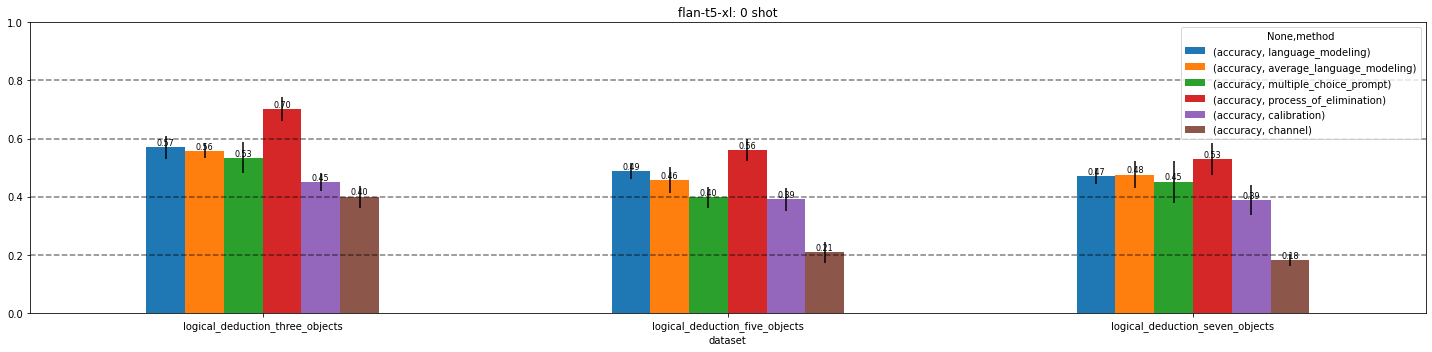

In [10]:
# plot flan-t5-xl on all benchmarks.
datasets="logical_deduction_three_objects logical_deduction_five_objects logical_deduction_seven_objects".split()
method_index = [('accuracy', 'language_modeling'), ('accuracy', 'average_language_modeling'), ('accuracy',    'multiple_choice_prompt'), ('accuracy',    'process_of_elimination')]
method_index += [('accuracy', 'calibration'), ('accuracy', 'channel')]
model = "flan-t5-xl"
fig, ax = plt.subplots(figsize=(20, 5))
ax.set_ylim([0.0, 1.0])
h_lines = [0.2, 0.4, 0.6, 0.8]
sing_df = df[(df["dataset"].isin(datasets)) & (df["checkpoint"] == model)]
sing_df.to_csv("num_option.csv")
sing_df = sing_df.groupby(["dataset","method"])
sing_means = sing_df.mean().unstack().reindex(method_index, axis="columns").reindex(datasets, axis="rows")
sing_errors = sing_df.std().unstack().reindex(method_index, axis="columns").reindex(datasets, axis="rows")
sing_means.plot.bar(yerr=sing_errors, rot=0, figsize=(20, 5), title=f"{model}: {n_shot} shot", legend=True, ax=ax)
# plot numbers on top of bars
for p in ax.patches:
        ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%.2f' % float(p.get_height()), ha='center', va='bottom', fontsize=8)
for line in h_lines:
    ax.axhline(line, color="black", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.savefig("num_option.png", dpi=300, bbox_inches='tight')